<a href="https://colab.research.google.com/github/mofuoku417/Univariate-Time-Series-Models-to-Predict-Crude-Palm-Oil-Price/blob/main/DL_CPO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Problem Statement
An accurate forecast of the price of crude palm oil (CPO) is vital to the economic growth of countries producing palm oil. Crude palm oil (CPO) price volatility represents a tremendous risk for critical players in the palm oil industry. The CPO fluctuates widely and shows a non-linear trend; for that reason, the prediction may be challenging. Most of the time series forecasts from the Commodity Price Forecasting Model use traditional statistical methods such as the Autoregressive Integrated Moving Average (ARIMA). In this investigation, HoltWinter's exponential smoothing model, artificial neural networks (ANN) or Multilayer perception (MLP), and long-term memory (LSTM) were used for univariate time series-based CPO price predictions for comparison performance.

## Data
The monthly CPO prices were retrieved from:https://www.indexmundi.com/commodities/?commodity=palm-oil&months=300 and analyzed for the periods between 1996 and 2021.

##Approach
In this code, we gathered the results of time-series forecasting for four particular datasets. First, we used one-step recursive forecasting in each of them as a univariate time collection forecasting problem. Next, we plotted the collected records primarily based on the metrics used. Finally, we used RMSE (Residual Mean Squared Error) and MAPE (Mean Absolute Percent Error) as our metrics for comparison. 
List of approaches:

*   Holt-Winters Smoothing Method (SES)
*   Holt-Winters Triple exponential Smoothing (TES)
*   Arima/Sarima
*   Ann Feedforward or MLP
*   LSTM








#### Use pip to install required packages: sklearn, pyramid and its flavors

In [103]:
!pip install sklearn
!pip install pyramid
!pip install pmdarima
!pip install pyramid-arima
!pip install pyramid.arima
!pip uninstall statsmodels 
!pip install statsmodels
!pip install pandas-bokeh
!pip install bokeh
!pip install jupyter_contrib_nbextensions && jupyter contrib nbextension install
!pip install pandas_bokeh

  Using cached pyramid-arima-0.8.1.tar.gz (515 kB)
  ERROR: Failed building wheel for pyramid-arima
  Running setup.py clean for pyramid-arima
Failed to build pyramid-arima
    Running setup.py install for pyramid-arima ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-_s9et90w/pyramid-arima_373132cd761b4c08a11029428ca4c76b/setup.py'"'"'; __file__='"'"'/tmp/pip-install-_s9et90w/pyramid-arima_373132cd761b4c08a11029428ca4c76b/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-5nruxjk3/install-record.txt --single-version-externally-managed --compile --install-headers /usr/local/include/python3.7/pyramid-arima Check the logs for ful

[I 02:05:04 InstallContribNbextensionsApp] jupyter contrib nbextension install 
[I 02:05:04 InstallContribNbextensionsApp] Installing jupyter_contrib_nbextensions nbextension files to jupyter data directory
[I 02:05:04 InstallContribNbextensionsApp] Installing /usr/local/lib/python3.7/dist-packages/jupyter_contrib_nbextensions/nbextensions/code_prettify -> code_prettify
[I 02:05:04 InstallContribNbextensionsApp] Up to date: /usr/local/share/jupyter/nbextensions/code_prettify/demo_2to3.gif
[I 02:05:04 InstallContribNbextensionsApp] Up to date: /usr/local/share/jupyter/nbextensions/code_prettify/code_prettify.js
[I 02:05:04 InstallContribNbextensionsApp] Up to date: /usr/local/share/jupyter/nbextensions/code_prettify/autopep8.js
[I 02:05:04 InstallContribNbextensionsApp] Up to date: /usr/local/share/jupyter/nbextensions/code_prettify/README_autopep8.md
[I 02:05:04 InstallContribNbextensionsApp] Up to date: /usr/local/share/jupyter/nbextensions/code_prettify/README.md
[I 02:05:04 InstallC

#### Import the libraries:

In [2]:
import pandas as pd
import bokeh
import matplotlib.pyplot as plt
import numpy as np
import pickle
import math
import keras
import tensorflow
import statsmodels.tsa as sm 
from pmdarima.arima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMAResults, ARIMA
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics import tsaplots
from statsmodels.graphics.gofplots import qqplot
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
import seaborn as sns
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, LSTM, Activation, Bidirectional, Flatten, TimeDistributed, SimpleRNN, Dropout, GRU, Input, Add, Multiply
from keras.layers.convolutional import Conv1D, MaxPooling1D
#from keras.layers.normalization import BatchNormalization
from keras import optimizers, initializers
from keras.regularizers import l2
from keras.initializers import TruncatedNormal, Constant, RandomNormal
from keras.layers.advanced_activations import LeakyReLU, ELU
from tensorflow.keras import optimizers
import plotly.express as px
optimizers.RMSprop()
import pickle
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [3]:
validation_split = 0.25 

#### Create functions to compute the outliers and metrics

In [4]:
#Calculate and locate the outliers
def find_outlier(ds, col):
  quart1 = ds[col].quantile(0.25)
  quart3 = ds[col].quantile(0.75)
  IQR = quart3 - quart1 #Inter-quartile range
  low_val = quart1 - 1.5*IQR
  high_val = quart3 + 1.5*IQR
  ds = ds.loc[(ds[col] < low_val) | (ds[col] > high_val)]
  return ds

#Remove the outliers
def remove_outlier(ds, col):
  quart1 = ds[col].quantile(0.25)
  quart3 = ds[col].quantile(0.75)
  IQR = quart3 - quart1 #Interquartile range
  low_val = quart1 - 1.5*IQR
  high_val = quart3 + 1.5*IQR
  df_out = ds.loc[(ds[col] > low_val) & (ds[col] < high_val)]
  return df_out

#Calculate the root mean squared error:
def RMSE(y_true, y_pred): 
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse

#Calculate the mean absolute percentage error
def MAPE(y_true, y_pred): 
    mape = np.mean(np.abs((np.array(y_true) - np.array(y_pred)) / np.array(y_true))) * 100
    return mape

#### Read in the crude palm oil monthly price to a data frame:

In [5]:
series = pd.read_csv('https://raw.githubusercontent.com/mofuoku417/Univariate-Time-Series-Models-to-Predict-Crude-Palm-Oil-Price/main/data.csv')
date_rng = pd.date_range(start='1996-09', end='2021-08', freq='MS')
series.head()

,Date,cpo_pri
0,1996-09,545.0
1,1996-10,532.0
2,1996-11,550.0
3,1996-12,561.0
4,1997-01,567.0


In [6]:
#Verify the 'datetime' column is a datetime64[ns] Dtype:
print(series.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     300 non-null    object 
 1   cpo_pri  300 non-null    float64
dtypes: float64(1), object(1)
memory usage: 4.8+ KB
None


####Visualize the Monthly Crude Palm Oil Time-Series

In [7]:
import plotly.express as px
from plotly.validators.scatter.marker import SymbolValidator
# plotly
fig = px.line(series, x='Date', y='cpo_pri')
fig.show(renderer="colab")

In [8]:
series['Date'] = pd.DataFrame(date_rng, columns=['Date'])

In [ ]:
#series.set_index('Date')

In [9]:
series.head()

,Date,cpo_pri
0,1996-09-01,545.0
1,1996-10-01,532.0
2,1996-11-01,550.0
3,1996-12-01,561.0
4,1997-01-01,567.0


####Save series dataframe

In [ ]:
#series2.to_csv('series2.csv')

###Detect outliers and visualize it

In [ ]:
#outliers = find_outlier(series, 'cpo_pri')
#print(outliers)
#sns.boxplot(series['cpo_pri'])
#plt.title("Box Plot before outlier removing")
#plt.show()

####Delete the Outlier

In [ ]:
#series = remove_outlier(series, 'cpo_pri')
#sns.boxplot(series['cpo_pri'])
#plt.title("Box Plot after outlier removing")
#plt.show()

####Saving the data

In [ ]:
#with open ('series_pickle', 'wb') as f:
  #pickle.dump(series, f)

#Recall the saved model
#with open('series_pickle', 'rb') as f:
  #series = pickle.load(f)

#### Decompose the time-series into its harmonic components

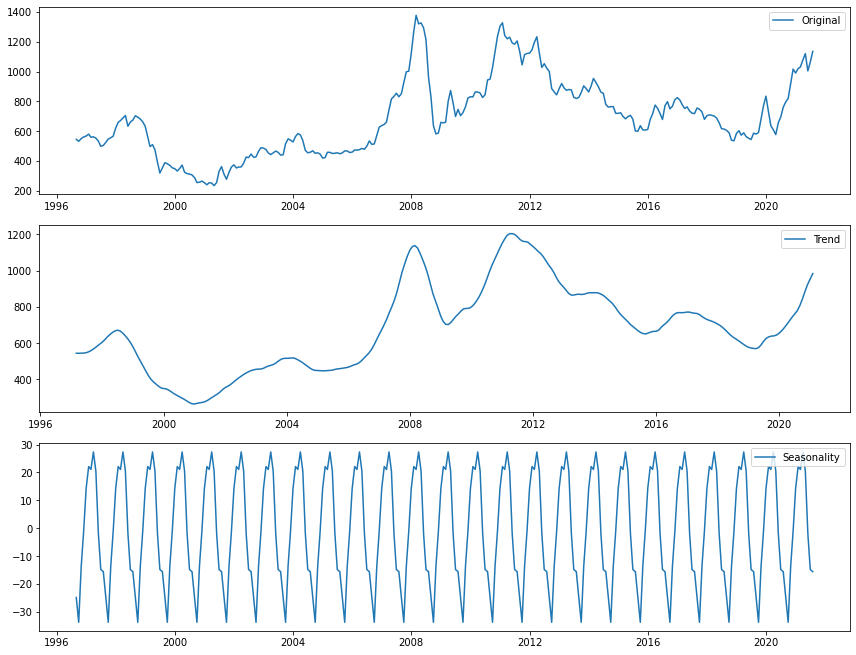

In [ ]:
ts = pd.Series(list(series['cpo_pri']), index=pd.to_datetime(series['Date'],format='%Y-%m'))
series.set_index('Date')
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(12,12))

plt.subplot(411)
plt.plot(ts, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.tight_layout()

In [ ]:
series.set_index('Date', inplace=True)

###Split into training and test set:

In [10]:
train_len = 225
train = series[0:train_len] 
test = series[train_len:] 

###Simple Exponential Smoothing (SES)

In [11]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
Holt_pred = test.copy()
Holt_model = ExponentialSmoothing(np.asarray(train['cpo_pri']) ,seasonal_periods=12 ,trend='additive', seasonal=None)
Holt_model_fit = Holt_model.fit(smoothing_level=0.2, smoothing_slope=0.01, optimized=False)
print(Holt_model_fit.params)
Holt_pred['holt_forecast'] = Holt_model_fit.forecast(len(test))

{'smoothing_level': 0.2, 'smoothing_trend': 0.01, 'smoothing_seasonal': None, 'damping_trend': nan, 'initial_level': 550.6666666666663, 'initial_trend': 0.6424242424242834, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning:

the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead



####Plot train, test and forecast

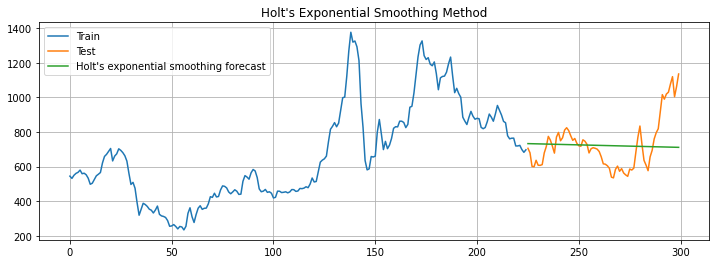

In [12]:
plt.figure(figsize=(12,4))
plt.grid()
plt.plot( train['cpo_pri'], label='Train')
plt.plot(test['cpo_pri'], label='Test')
plt.plot(Holt_pred['holt_forecast'], label='Holt\'s exponential smoothing forecast')
plt.legend(loc='best')
plt.title('Holt\'s Exponential Smoothing Method')
plt.show()

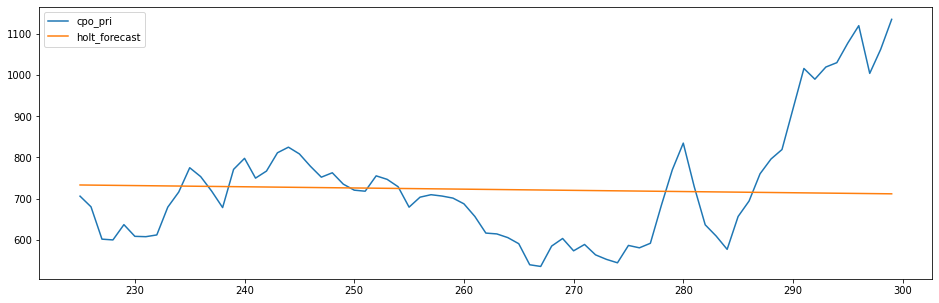

In [13]:
test['cpo_pri'].plot(figsize = (16,5), legend=True)
Holt_pred['holt_forecast'].plot(legend = True);

#### Compute the metrics for the Holt model

In [14]:
rmse_Holt = RMSE(test['cpo_pri'], Holt_pred['holt_forecast']).round(2)
mape_Holt = np.round(np.mean(np.abs(test['cpo_pri']-Holt_pred['holt_forecast'])/test['cpo_pri'])*100,2)
Metrics = {"RMSE_HOLT": rmse_Holt, "MAPE_HOLT": mape_Holt}
Metrics

{'MAPE_HOLT': 14.63, 'RMSE_HOLT': 148.19}

####Save the Holt Model

In [15]:
Holt = Holt_pred['holt_forecast'] 

In [ ]:
#Holt.to_csv('holt_pred.csv')

In [ ]:
#header_list = ["Month", "holt_pred"]
#Holt = pd.read_csv("holt_pred.csv")

In [ ]:
#with open ('Holt_pickle', 'wb') as f:
  #pickle.dump(Holt, f)

#Recall the saved model
#with open('Holt_pickle', 'rb') as f:
  #Holt = pickle.load(f)

###Triple Exponential Smoothing (TES)

In [16]:
HoltM_pred = test.copy()
HoltM_model = ExponentialSmoothing(np.asarray(train['cpo_pri']) ,seasonal_periods=12 ,trend='add', seasonal='mul')
HoltM_model_fit = HoltM_model.fit(optimized=True)
print(HoltM_model_fit.params)
HoltM_pred['hw_forecast'] = HoltM_model_fit.forecast(75)

{'smoothing_level': 0.92435765492454, 'smoothing_trend': 0.0010661544408025606, 'smoothing_seasonal': 0.07556336044676666, 'damping_trend': nan, 'initial_level': 529.3758701429153, 'initial_trend': -1.0167188211280316, 'initial_seasons': array([1.07852716, 1.0694969 , 1.11245147, 1.14195162, 1.19884949,
       1.22581563, 1.20009336, 1.21363336, 1.23133852, 1.15457334,
       1.12118433, 1.07997993]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


####Plot train, test and forecast

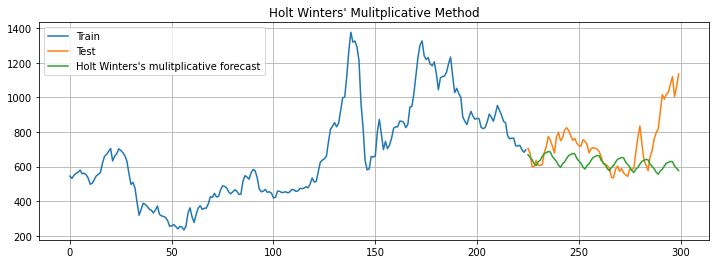

In [17]:
plt.figure(figsize=(12,4))
plt.grid()
plt.plot( train['cpo_pri'], label='Train')
plt.plot(test['cpo_pri'], label='Test')
plt.plot(HoltM_pred['hw_forecast'], label='Holt Winters\'s mulitplicative forecast')
plt.legend(loc='best')
plt.title('Holt Winters\' Mulitplicative Method')
plt.show()

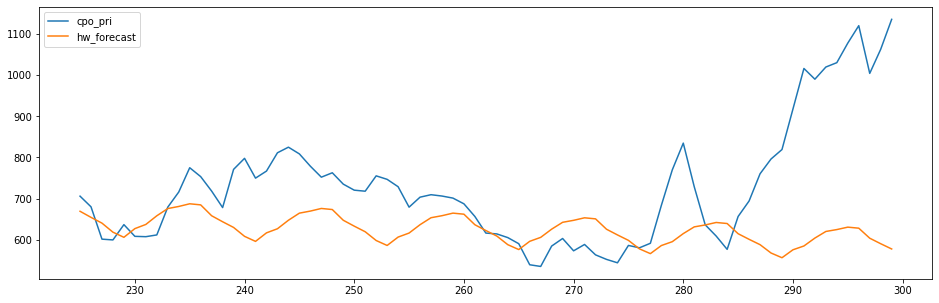

In [18]:
test['cpo_pri'].plot(figsize = (16,5), legend=True)
HoltM_pred['hw_forecast'].plot(legend = True);

####Compute the metrics for the Holt-Winters (TES)

In [19]:
Metrics['RMSE_HoltM'] = RMSE(test['cpo_pri'], HoltM_pred['hw_forecast']).round(2)
Metrics['MAPE_HoltM'] = MAPE(test['cpo_pri'], HoltM_pred['hw_forecast'])
Metrics

{'MAPE_HOLT': 14.63,
 'MAPE_HoltM': 15.065364163568438,
 'RMSE_HOLT': 148.19,
 'RMSE_HoltM': 185.04}

####Inference
##### Based on the RMSE values the Holt Exponential Smoothing Method is best in the Holt-Winters lot

####Save the Metrics to a dataframe

In [20]:
Metrics_1 = pd.DataFrame(Metrics.items(), columns=['RMSE|MAPE', 'Output'])

In [21]:
Metrics_1

,RMSE|MAPE,Output
0,RMSE_HOLT,148.190000
1,MAPE_HOLT,14.630000
2,RMSE_HoltM,185.040000
3,MAPE_HoltM,15.065364


####Save Metrics_1

In [ ]:
#with open ('Metrics_1_pickle', 'wb') as f:
  #pickle.dump(Metrics_1, f)

#Recall the saved model
#with open('Metrics_1_pickle', 'rb') as f:
  #Metrics_1 = pickle.load(f)

###ARIMA

In [22]:
scaler = MinMaxScaler(feature_range=(0, 1))
df = pd.DataFrame({"cpo_pri":scaler.fit_transform(np.array(series['cpo_pri']).reshape(len(series),1)).reshape(len(series),)}, index = series.index)

In [23]:
df.head()

,cpo_pri
0,0.272039
1,0.260667
2,0.276412
3,0.286034
4,0.291283


####Split Data into Training and Test Data

In [24]:
trainfrac = 0.75
df_train, df_test = train_test_split(df, train_size=trainfrac, shuffle=False, stratify=None)

In [25]:
df_train

,cpo_pri
0,0.272039
1,0.260667
2,0.276412
3,0.286034
4,0.291283
...,...
220,0.424800
221,0.427774
222,0.406623
223,0.392532


####Plot the ACF and ADF

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



ADF test results: (-1.8882387166069614, 0.3376140566740712, 12, 287, {'1%': -3.453342167806272, '5%': -2.871663828287282, '10%': -2.572164381381345}, -1051.2578796225114)
High p-value of ADF test (0.3376140566740712) shows that we fail to reject null hypothesis. 
 Hence, the dataset is non-stationary.


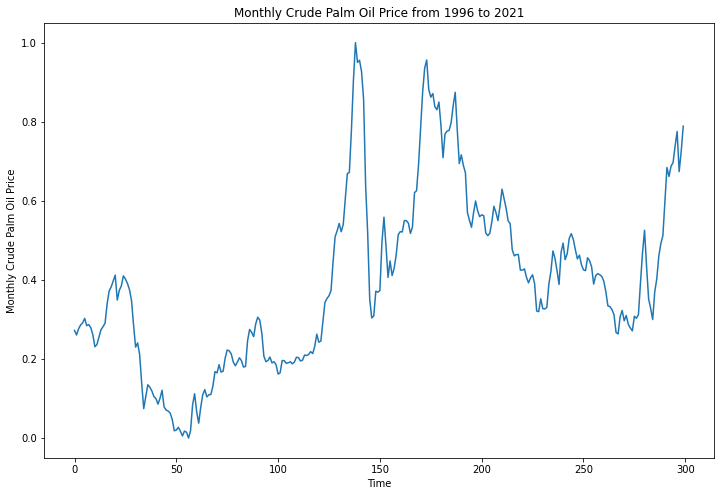

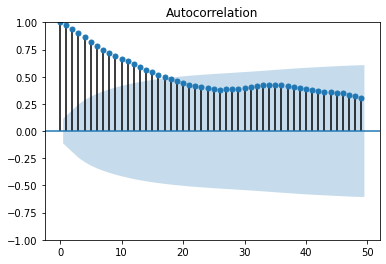

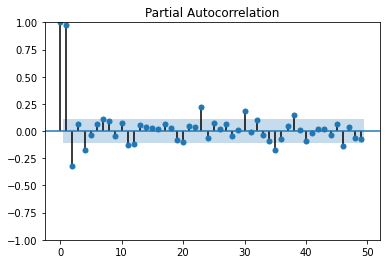

In [26]:
plt.figure(figsize=(12,8))
plt.plot(df)
plt.xlabel('Time')
plt.ylabel('Monthly Crude Palm Oil Price')
plt.title('Monthly Crude Palm Oil Price from 1996 to 2021')
plt.savefig('fig1.png', dpi=800, quality=95)
tsaplots.plot_acf(df, ax=None, lags=np.arange(50), use_vlines=True)
tsaplots.plot_pacf(df, ax=None, lags=np.arange(50), use_vlines=True)
print("ADF test results:", sm.stattools.adfuller(df.iloc[:,0], autolag='AIC'))
print('High p-value of ADF test ({}) shows that we fail to reject null hypothesis. \n Hence, the dataset is non-stationary.'.format(sm.stattools.adfuller(df.iloc[:,0], autolag='AIC')[1]))

#####The ACF and PACF graphs show a significant correlation between lags, so the data is not stationary. One method is to remove the trend by moving average and make it stationary for classical analysis. Manual decomposition of trend and seasonality: Use the smoothing method of moving average to remove the trend

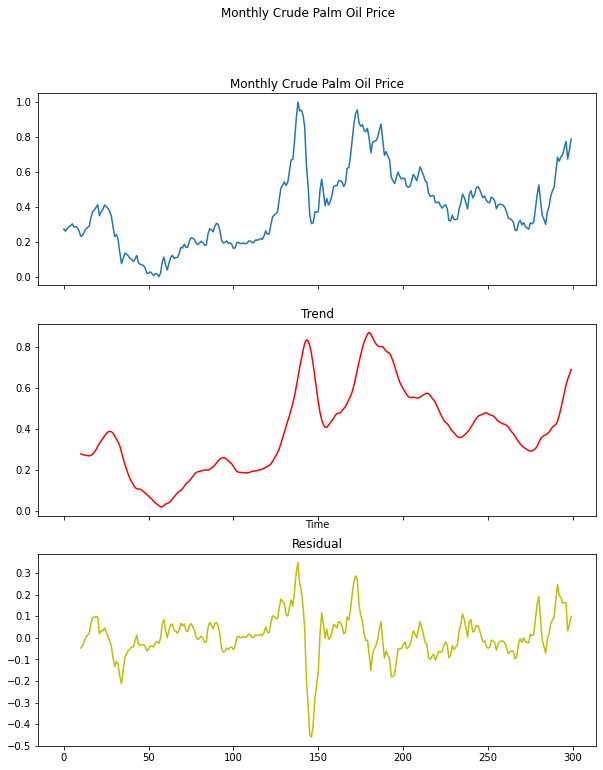

In [27]:
trendcomp = (df.rolling(10).mean()).rolling(2).mean()
res = (df - trendcomp).dropna()
noise = df.iloc[:,0] - trendcomp.iloc[:,0] 
df['trendcomp'] = trendcomp.values
df['noise'] = noise.values
fig = plt.figure(1, figsize=[10,12])
fig.suptitle('Monthly Crude Palm Oil Price')
fig1, fig2, fig4 = fig.subplots(nrows=3, ncols=1, sharex=True, sharey=False)
fig1.set_title('Monthly Crude Palm Oil Price')
fig2.set_title('Trend')
fig4.set_title('Residual')
fig2.set_xlabel('Time')
fig1.plot(df.loc[:,'cpo_pri'])
fig2.plot(df.loc[:,'trendcomp'], 'r')
fig4.plot(df.loc[:,'noise'], 'y')
fig.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:824: FutureWarning:

trend 'nc' has been renamed to 'n' after 0.14 is released. Use 'n' now to avoid this warning.



ADF test results: (-4.58025133338892, 6.704829441937923e-06, 11, 278, {'1%': -2.5738293768438485, '5%': -1.9420082745076648, '10%': -1.6158985409993003}, -1036.4358111460283)
low p-value of ADF test (0.0001270024965905912) Show that we reject the null hypothesis. So the residuals are almost stationary.
The P value of the ADF test (no constant, no trend) indicates that the data is stationary. So we can say that the data has a stationary trend.


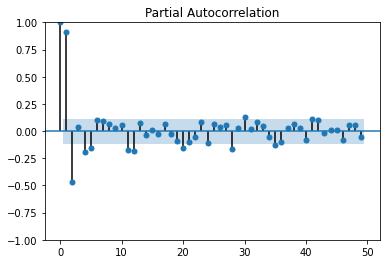

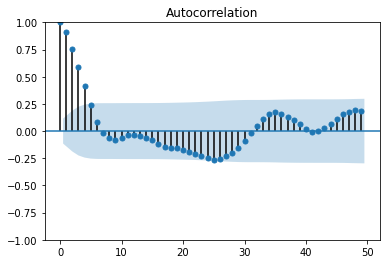

In [28]:
tsaplots.plot_pacf(noise.dropna(), ax=None, lags=np.arange(50), use_vlines=True)
tsaplots.plot_acf(noise.dropna(), ax=None, lags=np.arange(50), use_vlines=True)
#ADF test on residual
print("ADF test results:", sm.stattools.adfuller(df.loc[:,'noise'].dropna(), regression='nc', autolag='AIC'))
print('low p-value of ADF test ({}) Show that we reject the null hypothesis. So the residuals are almost stationary.'.format(sm.stattools.adfuller(df.loc[:,'noise'].dropna(), autolag='AIC')[1]))
print('The P value of the ADF test (no constant, no trend) indicates that the data is stationary. So we can say that the data has a stationary trend.')

#####As we have seen, it is not easy to remove trend components through moving averages. Another way is to do differencing between data sets. Manually decompose seasonality and trend: Differencing method to see if the time series is difference stationary!


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:824: FutureWarning:

trend 'nc' has been renamed to 'n' after 0.14 is released. Use 'n' now to avoid this warning.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:824: FutureWarning:

trend 'nc' has been renamed to 'n' after 0.14 is released. Use 'n' now to avoid this warning.



ADF test results: (-4.535511442557681, 8.11908899021424e-06, 11, 287, {'1%': -2.5735742774587527, '5%': -1.941975420474441, '10%': -1.61592644081746}, -1046.7946031539327)
The low p-value of ADF test (8.11908899021424e-06) indicates that we will reject null hypothesis. 
 Hence, the residual is close to stationary.
Data is not getting stationary by multiple differencings. So data is trend stationary.


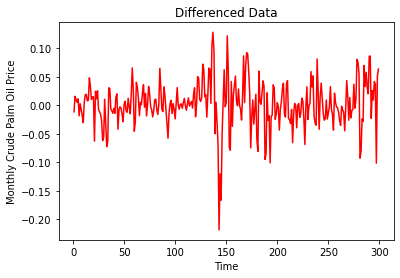

In [29]:
diff1 = df.loc[:,'cpo_pri'].diff(1)
nn = diff1.dropna()
plt.plot(nn,'r')
plt.title('Differenced Data')
plt.xlabel('Time')
plt.ylabel('Monthly Crude Palm Oil Price')

# ADF test on difference data:
print("ADF test results:", sm.stattools.adfuller(nn, regression='nc', autolag='AIC'))
print('The low p-value of ADF test ({}) indicates that we will reject null hypothesis. \n Hence, the residual is close to stationary.'.format(sm.stattools.adfuller(nn, regression='nc', autolag='AIC')[1]))
print('Data is not getting stationary by multiple differencings. So data is trend stationary.')

#### ARIMA Hyperparameter Optimization

In [30]:
stepwise_fit = auto_arima(df_train['cpo_pri'] , start_p = 1, start_q = 1,
                          max_p = 3, max_q = 3, m = 12,
                          start_P = 0, seasonal = True,
                          d = None, D = 1, trace = True,
                          error_action ='ignore',   
                          suppress_warnings = True,  
                          stepwise = True)        
  
# To print the summary
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.36 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-83.627, Time=0.07 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-646.903, Time=1.07 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=-342.747, Time=0.83 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-85.058, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=-601.784, Time=0.25 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=-675.917, Time=2.74 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=4.82 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.77 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=-121.606, Time=1.06 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=-720.647, Time=4.82 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=-702.448, Time=1.55 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=4.93 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.52 sec
 ARIMA(3,0,0)(2,1,0)[12] intercept   : AIC=-71

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  225
Model:             SARIMAX(2, 0, 0)x(2, 1, 0, 12)   Log Likelihood                 366.306
Date:                            Sun, 24 Oct 2021   AIC                           -722.611
Time:                                    01:22:50   BIC                           -705.805
Sample:                                         0   HQIC                          -715.819
                                            - 225                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4094      0.057     24.518      0.000       1.297       1.522
ar.L2         -0.4525      0.056     -8.009      0.000      -0.563      -0.342
ar.S.L12      -0.6419      0.048    -13.472      0.000      -0.735      -0.549
ar.S.L24      -0.3066      0.067     -4.556      0.000      -0.438      -0.175
sigma2         0.0018      0.000     12.529      0.000       0.002       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.32   Jarque-Bera (JB):                24.01
Prob(Q):                              0.57   Prob(JB):                         0.00
Heteroskedasticity (H):               3.15   Skew:                            -0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

####Inference

* The minimum AIC value was obtained by p=2, d=0, q=0 paramteres.
* SARIMA(2,0,0)x(2,1,0)12 will be chosen as the best model.


####Based on the results of the tests, we specify the SARIMA model and fit it to the data:

####Develop the Sarima Model

In [31]:
arima_model = SARIMAX(df_train['cpo_pri'], 
                order = (2, 0, 0), 
                seasonal_order =(2, 1, 0, 12))
  
arima_result = arima_model.fit()
arima_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                            cpo_pri   No. Observations:                  225
Model:             SARIMAX(2, 0, 0)x(2, 1, 0, 12)   Log Likelihood                 366.306
Date:                            Sun, 24 Oct 2021   AIC                           -722.611
Time:                                    01:23:01   BIC                           -705.805
Sample:                                         0   HQIC                          -715.819
                                            - 225                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4094      0.057     24.518      0.000       1.297       1.522
ar.L2         -0.4525      0.056     -8.009      0.000      -0.563      -0.342
ar.S.L12      -0.6419      0.048    -13.472      0.000      -0.735      -0.549
ar.S.L24      -0.3066      0.067     -4.556      0.000      -0.438      -0.175
sigma2         0.0018      0.000     12.529      0.000       0.002       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.32   Jarque-Bera (JB):                24.01
Prob(Q):                              0.57   Prob(JB):                         0.00
Heteroskedasticity (H):               3.15   Skew:                            -0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [32]:
arima_pred = arima_result.predict(start = len(df_train), end = len(df)-1, typ="levels").rename("ARIMA_Predictions")
arima_pred

225    0.399210
226    0.411901
227    0.395980
228    0.401715
229    0.394620
         ...   
295    0.428056
296    0.432634
297    0.423480
298    0.425207
299    0.398734
Name: ARIMA_Predictions, Length: 75, dtype: float64

In [33]:
df_test['ARIMA_Predictions'] = arima_pred

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



####Plot the Sarima Prediction

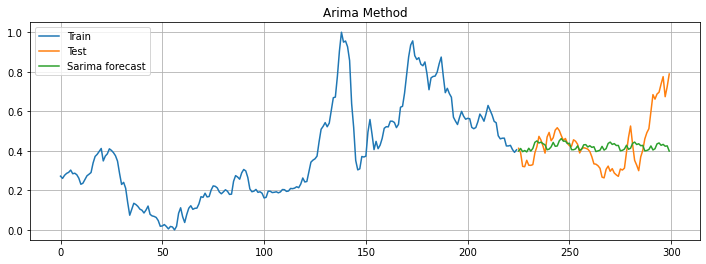

In [34]:
plt.figure(figsize=(12,4))
plt.grid()
plt.plot( df_train['cpo_pri'], label='Train')
plt.plot(df_test['cpo_pri'], label='Test')
plt.plot(df_test['ARIMA_Predictions'], label='Sarima forecast')
plt.legend(loc='best')
plt.title('Arima Method')
plt.show()

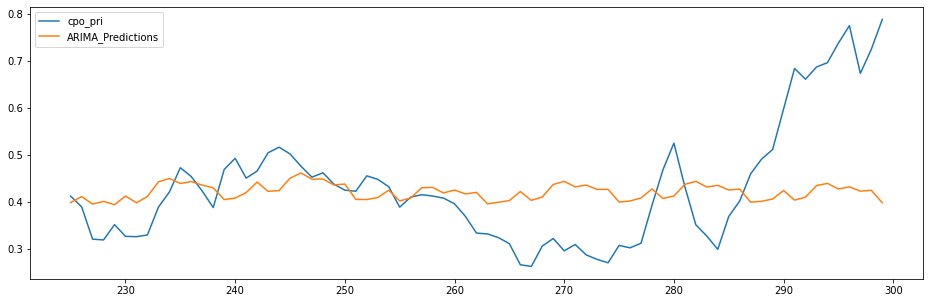

In [35]:
df_test['cpo_pri'].plot(figsize = (16,5), legend=True)
arima_pred.plot(legend = True);

####Save the Sarima Prediction

In [ ]:
#with open ('arima_pred_pickle', 'wb') as f:
  #pickle.dump(arima_pred, f)

#Recall the saved model
#with open('arima_pred_pickle', 'rb') as f:
  #arima_pred = pickle.load(f)

In [ ]:
#arima_pred.values.reshape(-1,1)

#### Compute the metrics for the ARIMA model

In [60]:
Metrics['RMSE_ARIMA'] = RMSE(df_test['cpo_pri'], arima_pred)
Metrics['MAPE_ARIMA'] = MAPE(df_test['cpo_pri'], arima_pred)
Metrics

{'MAPE_ARIMA': 21.147663793018136,
 'MAPE_HOLT': 14.63,
 'MAPE_HoltM': 15.065364163568438,
 'RMSE_ARIMA': 0.12696651650158114,
 'RMSE_HOLT': 148.19,
 'RMSE_HoltM': 185.04}

## Application of deep learning to the Monthly Crude Palm Oil Data

#### Prepare the dataset

In [38]:
#this function generates the input output
def input_output_generator(z,n):
    #generate the input output sets for mlp models
    x_train = []
    y_train = []
    x_test = []
    y_test = z[math.floor(trainfrac*len(z)):]
    z_train = z[:math.floor(trainfrac*len(z))]
    for i in range(len(z_train)-n):
        x_train.append(z[i:i+n])
        y_train.append(z[i+n])
    for i in range(len(y_test)):
        x_test.append(z[len(z_train)-n+i:len(z_train)+i])
    return np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)

#### Build the models and tune the parameters:

In [39]:
def Model_Build(Type,nodes,X_train, optimizer, learning_rate):
    # this function creates the model. Type is the type of deep learning model. It could be MLP, LSTM, ...
    # Nodes defines the sequence of nodes in different layers of network. It should be a list.
    # Optimizer and learning rate are used for compiling the model
    model = Sequential()
    if Type == 'MLP':
        model.add(Dense(nodes[0], activation='relu', input_shape=(X_train.shape[1],),
                        kernel_initializer='random_uniform', bias_initializer='RandomNormal'))
        for i in range(len(nodes)-1):
            model.add(Dense(nodes[i+1], activation='relu', kernel_initializer='random_uniform',
                            bias_initializer='RandomNormal'))

    if Type == 'LSTM':
        model.add(LSTM(nodes, activation='relu', kernel_initializer='RandomNormal',
                       input_shape=(X_train[1,:].shape)))
        model.add(Dense(1))
 
    if optimizer == 'SGD':
        sgd = optimizers.SGD(lr=learning_rate, momentum=0)
        model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy', 'mse'])
    if optimizer == 'RMSprop':
        rmsprop = optimizers.RMSprop(lr=learning_rate, rho=0.9)
        model.compile(loss='mean_squared_error', optimizer=rmsprop, metrics=['accuracy', 'mse'])
    if optimizer == 'Adagrad':
        adagrad = optimizers.Adagrad(lr=learning_rate)
        model.compile(loss='mean_squared_error', optimizer=adagrad, metrics=['accuracy', 'mse'])
    if optimizer == 'Adadelta':
        adadelta = optimizers.Adadelta(lr=learning_rate, rho=0.95)
        model.compile(loss='mean_squared_error', optimizer=adadelta, metrics=['accuracy', 'mse'])
    if optimizer == 'Adam':
        adam = optimizers.Adam(learning_rate)
        model.compile(loss='mean_squared_error', optimizer=adam, metrics=['accuracy', 'mse'])
    return model

def Tune_epoch(Type, X_train, Y_train, nodes, val_split, epochs, batch_size, optimizer, learning_rate):
    #this funciton tunes number of epochs of the model.
    e = [0 for i in range(len(epochs))]
    ii = 0
    for i in epochs:
        model = Model_Build(Type,nodes,X_train, optimizer, learning_rate)
        history_lstm = model.fit(X_train, Y_train, validation_split=val_split, epochs=i, batch_size=batch_size, verbose=0, shuffle=False)
        e[ii] = history_lstm.history['val_loss'][-1]
        ii += 1
    return e

def Tune_nodes(Type, X_train, Y_train, nodes, val_split, epochs, batch_size, optimizer, learning_rate):
    #this function tunes number of nodes.
    e = {}
    if np.size(np.shape(nodes)) == 1:
        for i in nodes:
            model = Model_Build(Type, i, X_train, optimizer, learning_rate)
            history = model.fit(X_train, Y_train, validation_split=val_split, epochs=epochs, batch_size=batch_size, verbose=0, shuffle=False)
            e[i] = history.history['val_loss'][-1]
    else:
        for i in range(np.shape(nodes)[0]):
            model = Model_Build(Type, nodes[i], X_train, optimizer, learning_rate)
            history = model.fit(X_train, Y_train, validation_split=val_split, epochs=epochs, batch_size=batch_size, verbose=0, shuffle=False)
            e[i] = history.history['val_loss'][-1]
    return e

def Tune_optimizer(Type, X_train, Y_train, nodes, val_split, epochs, batch_size, optimizer, learning_rate):
    #this function tunes the optimizer and the learning rate.
    e = {}
    for i in range(len(optimizer)):
        for j in range(len(learning_rate)):
            model = Model_Build(Type, nodes, X_train, optimizer[i], learning_rate[j])
            history = model.fit(X_train, Y_train, validation_split=val_split, epochs=epochs, batch_size=batch_size, verbose=0, shuffle=False)
            e[optimizer[i]+', rate='+str(learning_rate[j])] = history.history['val_loss'][-1]
    return e

def Tune_batch(Type, X_train, Y_train, nodes, val_split, epochs, batch_size, optimizer, learning_rate):
    #this function tunes the batch size.
    e = {}
    for i in batch_size:
        model = Model_Build(Type, nodes, X_train, optimizer, learning_rate)
        history = model.fit(X_train, Y_train, validation_split=val_split, epochs=epochs, batch_size=i, verbose=0, shuffle=False)
        e[i] = history.history['val_loss'][-1]
    return e

In [40]:
lag_mlp = 5 # lag is number of previous steps
X_train_mlp, Y_train_mlp, X_test_mlp, Y_test_mlp = input_output_generator(df['cpo_pri'].tolist(), lag_mlp)

In [41]:
#tuning optimizer. This can give us a good starting point.
opt = ['Adam', 'Adagrad']
lr = [0.001, 0.01]
nodes = [64,32,8,1]
e = Tune_optimizer('MLP', X_train_mlp, Y_train_mlp, nodes, validation_split, 50, 10, opt, lr)
optimizer = (min(e, key=e.get)).split(', ')[0]
learning_rate = float(((min(e, key=e.get)).split(', ')[1]).split('=')[1])
e

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



{'Adagrad, rate=0.001': 0.4366205036640167,
 'Adagrad, rate=0.01': 0.13719528913497925,
 'Adam, rate=0.001': 0.003635713364928961,
 'Adam, rate=0.01': 0.4366205036640167}

In [42]:
# tuning number of layers and nodes in MLP 
#we will give few candidates for comparing
nodes = [[200,100,50,1],[64,32,16,1],[128,64,16,1]]
e = Tune_nodes('MLP', X_train_mlp, Y_train_mlp, nodes, validation_split, 50, 10, optimizer, learning_rate)
e

{0: 0.4366205036640167, 1: 0.4366205036640167, 2: 0.4366205036640167}

In [43]:
nodes_mlp = [200, 100, 50, 1]

In [44]:
#tune batch size
batch = [5, 10, 30]
e = Tune_batch('MLP', X_train_mlp, Y_train_mlp, nodes_mlp, validation_split, 50, batch, optimizer, learning_rate)
batch_size = int(min(e, key=e.get))

### MLP

#### Build the model

In [45]:
batch_size = 10
nodes_mlp = [100, 50, 20, 1]
optimizer = 'Adam'
learning_rate = 0.001

Epoch 1/200
17/17 [==============================] - 1s 10ms/step - loss: 0.1022 - accuracy: 0.0061 - mse: 0.1022 - val_loss: 0.3544 - val_accuracy: 0.0000e+00 - val_mse: 0.3544
Epoch 2/200
17/17 [==============================] - 0s 3ms/step - loss: 0.0841 - accuracy: 0.0061 - mse: 0.0841 - val_loss: 0.2972 - val_accuracy: 0.0000e+00 - val_mse: 0.2972
Epoch 3/200
17/17 [==============================] - 0s 4ms/step - loss: 0.0559 - accuracy: 0.0061 - mse: 0.0559 - val_loss: 0.1844 - val_accuracy: 0.0000e+00 - val_mse: 0.1844
Epoch 4/200
17/17 [==============================] - 0s 4ms/step - loss: 0.0286 - accuracy: 0.0061 - mse: 0.0286 - val_loss: 0.0696 - val_accuracy: 0.0000e+00 - val_mse: 0.0696
Epoch 5/200
17/17 [==============================] - 0s 4ms/step - loss: 0.0285 - accuracy: 0.0061 - mse: 0.0285 - val_loss: 0.0433 - val_accuracy: 0.0000e+00 - val_mse: 0.0433
Epoch 6/200
17/17 [==============================] - 0s 3ms/step - loss: 0.0277 - accuracy: 0.0061 - mse: 0.0277 -

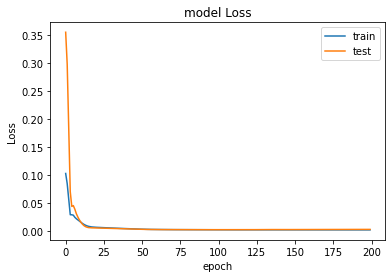

In [46]:
model_mlp = Model_Build('MLP', nodes_mlp, X_train_mlp, optimizer, learning_rate)
history_mlp = model_mlp.fit(X_train_mlp, Y_train_mlp, validation_split=validation_split, epochs=200,
                            batch_size=batch_size, verbose=1, shuffle=False)
plt.plot(history_mlp.history['loss'])
plt.plot(history_mlp.history['val_loss'])
plt.title('model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

Epoch 1/200
17/17 [==============================] - 1s 10ms/step - loss: 0.0904 - accuracy: 0.0061 - mse: 0.0904 - val_loss: 0.3198 - val_accuracy: 0.0000e+00 - val_mse: 0.3198
Epoch 2/200
17/17 [==============================] - 0s 3ms/step - loss: 0.0642 - accuracy: 0.0061 - mse: 0.0642 - val_loss: 0.2188 - val_accuracy: 0.0000e+00 - val_mse: 0.2188
Epoch 3/200
17/17 [==============================] - 0s 3ms/step - loss: 0.0337 - accuracy: 0.0061 - mse: 0.0337 - val_loss: 0.0893 - val_accuracy: 0.0000e+00 - val_mse: 0.0893
Epoch 4/200
17/17 [==============================] - 0s 3ms/step - loss: 0.0328 - accuracy: 0.0061 - mse: 0.0328 - val_loss: 0.0555 - val_accuracy: 0.0000e+00 - val_mse: 0.0555
Epoch 5/200
17/17 [==============================] - 0s 2ms/step - loss: 0.0318 - accuracy: 0.0061 - mse: 0.0318 - val_loss: 0.0565 - val_accuracy: 0.0000e+00 - val_mse: 0.0565
Epoch 6/200
17/17 [==============================] - 0s 3ms/step - loss: 0.0266 - accuracy: 0.0061 - mse: 0.0266 -

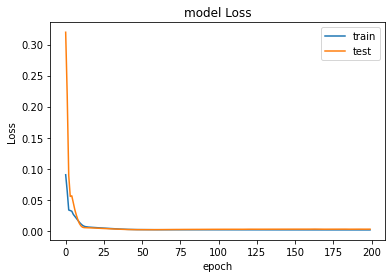

In [48]:
# 50 epochs are enough for training the model.
model_mlp = Model_Build('MLP', nodes_mlp, X_train_mlp, optimizer, learning_rate)
history_mlp = model_mlp.fit(X_train_mlp, Y_train_mlp, epochs=200,validation_split=validation_split,
                            batch_size=batch_size, verbose=1, shuffle=False)
plt.plot(history_mlp.history['loss'])
plt.plot(history_mlp.history['val_loss'])
plt.title('model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [61]:
trainprediction_mlp = model_mlp.predict(X_train_mlp)
testprediction_mlp = model_mlp.predict(X_test_mlp)
trainprediction_mlp = pd.DataFrame(index=df.index[lag_mlp:len(df)-len(X_test_mlp)], data=trainprediction_mlp)
testprediction_mlp = pd.DataFrame(index=df.index[len(df)-len(X_test_mlp):], data=testprediction_mlp)

####Plot the MLP prediction

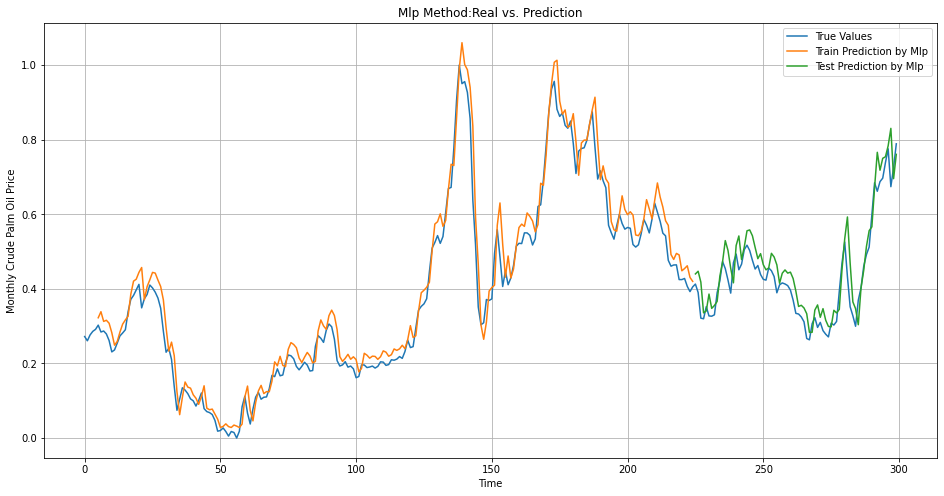

In [62]:
plt.figure(figsize=(16,8))
plt.grid()
plt.plot(df.index, df.cpo_pri, label = 'Train')
plt.plot(trainprediction_mlp,  label = 'Test')
plt.plot(testprediction_mlp,label = 'mlp forecast')
plt.legend(['True Values', 'Train Prediction by Mlp', 'Test Prediction by Mlp'],loc='best')
plt.title('Mlp Method:Real vs. Prediction')
plt.ylabel('Monthly Crude Palm Oil Price')
plt.xlabel('Time')
plt.show()

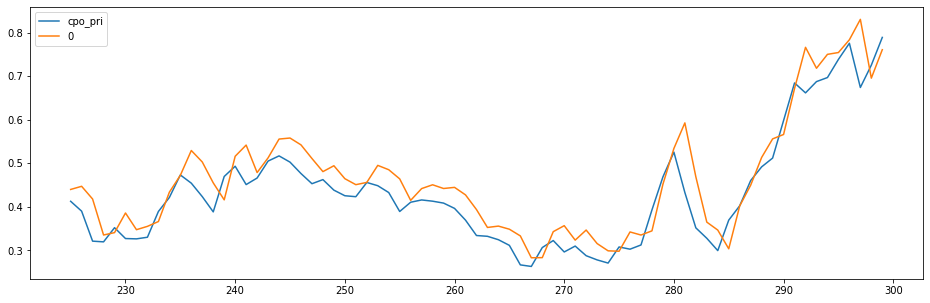

In [63]:
ax = df_test['cpo_pri'].plot(figsize = (16,5), legend=True)
testprediction_mlp.plot(ax=ax)

####Save the MLP prediction

In [ ]:
with open ('testprediction_mlp_pickle', 'wb') as f:
  pickle.dump(testprediction_mlp, f)

#Recall the saved model
#with open('testprediction_mlp_pickle', 'rb') as f:
  #testprediction_mlp = pickle.load(f)

In [64]:
Metrics['RMSE_MLP'] = RMSE(Y_test_mlp, testprediction_mlp)
Metrics['MAPE_MLP'] = MAPE(Y_test_mlp, testprediction_mlp)
Metrics

{'MAPE_ARIMA': 21.147663793018136,
 'MAPE_HOLT': 14.63,
 'MAPE_HoltM': 15.065364163568438,
 'MAPE_MLP': 34.51565328426192,
 'RMSE_ARIMA': 0.12696651650158114,
 'RMSE_HOLT': 148.19,
 'RMSE_HoltM': 185.04,
 'RMSE_MLP': 0.05201644635910986}

#### LSTM

In [65]:
def input_output_generator_LSTM(z,n):
    #generating input output sets for LSTM models
    x_train = []
    y_train = []
    x_test = []
    y_test = z[math.floor(trainfrac*len(z)):]
    z_train = z[:math.floor(trainfrac*len(z))]
    for i in range(len(z_train)-n):
        x_train.append(z[i:i+n])
        y_train.append(z[i+n])
    for i in range(len(y_test)):
        x_test.append(z[len(z_train)-n+i:len(z_train)+i])
    x_train = np.array(x_train)
    x_test = np.array(x_test)
    x_train_lstm = np.reshape(x_train,(x_train.shape[0], x_train.shape[1],1))
    x_test_lstm = np.reshape(x_test,(x_test.shape[0], x_test.shape[1],1))
    return x_train_lstm, np.array(y_train), x_test_lstm, np.array(y_test)

In [66]:
lag_lstm = 3
X_train_lstm, Y_train_lstm, X_test_lstm, Y_test_lstm = input_output_generator_LSTM(df['cpo_pri'].tolist(), lag_lstm)

In [67]:
#tuning optimizer. This can give us a good starting point.
opt = ['SGD', 'Adam']
lr = [0.001, 0.01, 0.1]
e = Tune_optimizer('LSTM', X_train_lstm, Y_train_lstm, 50, validation_split, 50, 10, opt, lr)
optimizer = (min(e, key=e.get)).split(', ')[0]
learning_rate = float(((min(e, key=e.get)).split(', ')[1]).split('=')[1])
e

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



{'Adam, rate=0.001': 0.0038493259344249964,
 'Adam, rate=0.01': 0.002352376701310277,
 'Adam, rate=0.1': 0.14558032155036926,
 'SGD, rate=0.001': 0.15305671095848083,
 'SGD, rate=0.01': 0.07498248666524887,
 'SGD, rate=0.1': 0.003393904073163867}

In [69]:
# tuning number of nodes in LSTM layer
nodes = [1, 10, 50, 100, 200, 500]
e = Tune_nodes('LSTM', X_train_lstm, Y_train_lstm, nodes, validation_split, 50, 10, optimizer, learning_rate)
nodes = int(min(e, key=e.get))

In [70]:
#tune batch size
batch = [1, 10, 20, 30]
e = Tune_batch('LSTM', X_train_lstm, Y_train_lstm, nodes, validation_split, 50,
               batch, optimizer, learning_rate)
batch_size = int(min(e, key=e.get))

#### Build the LSTM model

In [71]:
nodes = 500    
batch_size= 20  
learning_rate = 0.01
optimizer = 'Adam'
model_lstm = Model_Build('LSTM', nodes, X_train_lstm, optimizer, learning_rate)
model_lstm.summary()

Model: "sequential_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_39 (LSTM)               (None, 500)               1004000   
_________________________________________________________________
dense_91 (Dense)             (None, 1)                 501       
Total params: 1,004,501
Trainable params: 1,004,501
Non-trainable params: 0
_________________________________________________________________


Epoch 1/100
9/9 [==============================] - 1s 50ms/step - loss: 0.0337 - accuracy: 0.0060 - mse: 0.0337 - val_loss: 0.0482 - val_accuracy: 0.0000e+00 - val_mse: 0.0482
Epoch 2/100
9/9 [==============================] - 0s 23ms/step - loss: 0.0219 - accuracy: 0.0060 - mse: 0.0219 - val_loss: 0.0045 - val_accuracy: 0.0000e+00 - val_mse: 0.0045
Epoch 3/100
9/9 [==============================] - 0s 23ms/step - loss: 0.0169 - accuracy: 0.0120 - mse: 0.0169 - val_loss: 0.0561 - val_accuracy: 0.0000e+00 - val_mse: 0.0561
Epoch 4/100
9/9 [==============================] - 0s 22ms/step - loss: 0.0177 - accuracy: 0.0120 - mse: 0.0177 - val_loss: 0.0210 - val_accuracy: 0.0000e+00 - val_mse: 0.0210
Epoch 5/100
9/9 [==============================] - 0s 22ms/step - loss: 0.0196 - accuracy: 0.0120 - mse: 0.0196 - val_loss: 0.0075 - val_accuracy: 0.0000e+00 - val_mse: 0.0075
Epoch 6/100
9/9 [==============================] - 0s 21ms/step - loss: 0.0087 - accuracy: 0.0120 - mse: 0.0087 - val_lo

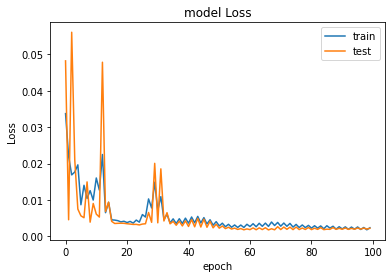

In [72]:
history_lstm = model_lstm.fit(X_train_lstm, Y_train_lstm, validation_split=validation_split, 
                              epochs=100, batch_size=batch_size, verbose=1, shuffle=False)
plt.plot(history_lstm.history['loss'])
plt.plot(history_lstm.history['val_loss'])
plt.title('model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [73]:
trainprediction_lstm = model_lstm.predict(X_train_lstm)
testprediction_lstm = model_lstm.predict(X_test_lstm)
trainprediction_lstm = pd.DataFrame(index=df.index[lag_lstm:len(df)-len(X_test_lstm)], data=trainprediction_lstm)
testprediction_lstm = pd.DataFrame(index=df.index[len(df)-len(X_test_lstm):], data=testprediction_lstm)

#### One-step ahead recursive forecasting:

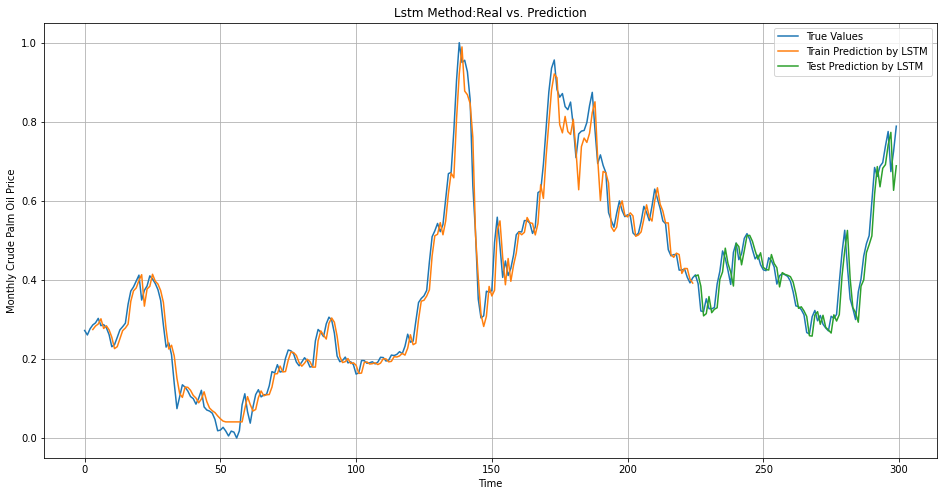

In [74]:
plt.figure(figsize=(16,8))
plt.grid()
plt.plot(df.index, df.cpo_pri, label = 'Train')
plt.plot(trainprediction_lstm,  label = 'Test')
plt.plot(testprediction_lstm,label = 'lstm forecast')
plt.legend(['True Values', 'Train Prediction by LSTM', 'Test Prediction by LSTM'],loc='best')
plt.title('Lstm Method:Real vs. Prediction')
plt.ylabel('Monthly Crude Palm Oil Price')
plt.xlabel('Time')
plt.show()

In [75]:
testprediction_lstm
testprediction_lstm = testprediction_lstm.rename(columns={0: "testprediction_lstm"})

In [76]:
testprediction_lstm

,testprediction_lstm
225,0.409787
226,0.412595
227,0.384048
228,0.309032
229,0.314702
...,...
295,0.691687
296,0.741322
297,0.773161
298,0.626544


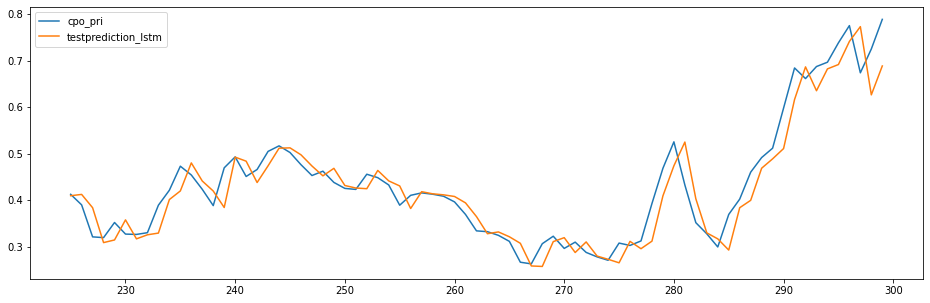

In [77]:
ax = df_test['cpo_pri'].plot(figsize = (16,5), legend=True)
testprediction_lstm.plot(ax=ax)

####Save the LSTM Prediction

In [ ]:
#with open ('testprediction_lstm_pickle', 'wb') as f:
  #pickle.dump(testprediction_lstm, f)

#Recall the saved model
#with open('testprediction_lstm_pickle', 'rb') as f:
  #testprediction_lstm = pickle.load(f)

#### Compute the metrics for the LSTM model

In [78]:
Metrics['RMSE_LSTM'] = RMSE(Y_test_lstm, testprediction_lstm)
Metrics['MAPE_LSTM'] = MAPE(Y_test_lstm, testprediction_lstm)
Metrics

{'MAPE_ARIMA': 21.147663793018136,
 'MAPE_HOLT': 14.63,
 'MAPE_HoltM': 15.065364163568438,
 'MAPE_LSTM': 30.870363222440783,
 'MAPE_MLP': 34.51565328426192,
 'RMSE_ARIMA': 0.12696651650158114,
 'RMSE_HOLT': 148.19,
 'RMSE_HoltM': 185.04,
 'RMSE_LSTM': 0.0408706095352583,
 'RMSE_MLP': 0.05201644635910986}

In [79]:
Metrics_2 = pd.DataFrame(Metrics.items(), columns=['RMSE|MAPE', 'Output'])

In [80]:
Metrics_2

,RMSE|MAPE,Output
0,RMSE_HOLT,148.190000
1,MAPE_HOLT,14.630000
2,RMSE_HoltM,185.040000
3,MAPE_HoltM,15.065364
4,RMSE_ARIMA,0.126967
5,MAPE_ARIMA,21.147664
6,RMSE_MLP,0.052016
7,MAPE_MLP,34.515653
8,RMSE_LSTM,0.040871
9,MAPE_LSTM,30.870363


##Result

###Comparing the Model Performance

In [81]:
frames = [Metrics_1, Metrics_2]
MetricsAll = pd.concat(frames)
MetricsAll

,RMSE|MAPE,Output
0,RMSE_HOLT,148.190000
1,MAPE_HOLT,14.630000
2,RMSE_HoltM,185.040000
3,MAPE_HoltM,15.065364
0,RMSE_HOLT,148.190000
1,MAPE_HOLT,14.630000
2,RMSE_HoltM,185.040000
3,MAPE_HoltM,15.065364
4,RMSE_ARIMA,0.126967
5,MAPE_ARIMA,21.147664


####Save MetricsAll

In [ ]:
#with open ('MetricsAll_pickle', 'wb') as f:
  #pickle.dump(MetricsAll, f)

#Recall the saved model
#with open('MetricsAll_pickle', 'rb') as f:
  #MetricsAll = pickle.load(f)

In [ ]:
#with open ('mofuoku417/Univariate-Time-Series-Models-to-Predict-Crude-Palm-Oil-Price/DL_CPO.ipynb/MetricsAll_pickle', 'wb') as f:
  #pickle.dump(MetricsAll, f)

#Recall the saved model
#with open('MetricsAll_pickle', 'rb') as f:
  #MetricsAll = pickle.load(f)

In [ ]:
#MetricsAll.save('mofuoku417/Univariate-Time-Series-Models-to-Predict-Crude-Palm-Oil-Price/DL_CPO.ipynb/MetricsAll_pickle')

In [ ]:
##DL_CPO.ipynb
### Multivariate-Time-Series-Forecasting-of-Crude-Palm-Oil-Price-Using-Machine-Learning-Techniques/DL_CPO.ipynb

####Create a Dictionary for only the RMSE for: Holt, Arima, mlp, and lstm Investigated

In [82]:
rsmeTable = pd.DataFrame({'Prediction Method':['RMSE_HOLT', 'RMSE_ARIMA', 'RMSE_MLP', 'RMSE_LSTM'], 'Result':[149.67,0.122,0.05,0.03]})

In [84]:
rsmeTable 

,Prediction Method,Result
0,RMSE_HOLT,149.670
1,RMSE_ARIMA,0.122
2,RMSE_MLP,0.050
3,RMSE_LSTM,0.030


####Retransform the Scaled Deep Learning Models

In [85]:
arima_predictions = arima_pred.values.reshape(-1,1)
arima_predictions = scaler.inverse_transform(arima_predictions)
df_test['arima_predictions'] = arima_predictions

df_test['testprediction_mlp'] = testprediction_mlp 
mlp_predictions = scaler.inverse_transform(testprediction_mlp)
df_test['mlp_predictions'] = mlp_predictions

lstm_predictions = scaler.inverse_transform(testprediction_lstm)
df_test['lstm_predictions'] = lstm_predictions
df_test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

,cpo_pri,ARIMA_Predictions,arima_predictions,testprediction_mlp,mlp_predictions,lstm_predictions
225,0.412790,0.399210,690.385192,0.439965,736.977356,702.476440
226,0.390126,0.411901,704.893816,0.447174,745.218628,705.686829
227,0.321355,0.395980,686.691839,0.418010,711.877136,673.051147
228,0.319711,0.401715,693.248328,0.335453,617.496765,587.292114
229,0.352224,0.394620,685.137705,0.340910,623.735107,593.773132
...,...,...,...,...,...,...
295,0.738309,0.428056,723.361692,0.754091,1096.091431,1024.750610
296,0.775371,0.432634,728.595277,0.783414,1129.615112,1081.493652
297,0.673904,0.423480,718.131056,0.830218,1183.121826,1117.893555
298,0.725136,0.425207,720.105354,0.695336,1028.922485,950.278076


####Reset index to Month

In [86]:
df_test = df_test.reset_index()

In [87]:
df_test

,index,cpo_pri,ARIMA_Predictions,arima_predictions,testprediction_mlp,mlp_predictions,lstm_predictions
0,225,0.412790,0.399210,690.385192,0.439965,736.977356,702.476440
1,226,0.390126,0.411901,704.893816,0.447174,745.218628,705.686829
2,227,0.321355,0.395980,686.691839,0.418010,711.877136,673.051147
3,228,0.319711,0.401715,693.248328,0.335453,617.496765,587.292114
4,229,0.352224,0.394620,685.137705,0.340910,623.735107,593.773132
...,...,...,...,...,...,...,...
70,295,0.738309,0.428056,723.361692,0.754091,1096.091431,1024.750610
71,296,0.775371,0.432634,728.595277,0.783414,1129.615112,1081.493652
72,297,0.673904,0.423480,718.131056,0.830218,1183.121826,1117.893555
73,298,0.725136,0.425207,720.105354,0.695336,1028.922485,950.278076


####Delete unwanted columns

In [88]:
df_test = df_test.drop(columns=['cpo_pri','ARIMA_Predictions', 'testprediction_mlp'])

In [89]:
df_test.head()

,index,arima_predictions,mlp_predictions,lstm_predictions
0,225,690.385192,736.977356,702.476440
1,226,704.893816,745.218628,705.686829
2,227,686.691839,711.877136,673.051147
3,228,693.248328,617.496765,587.292114
4,229,685.137705,623.735107,593.773132


###Load Holt-Winters Model

In [90]:
header_list = ["Month", "holt_pred"]
Holt = pd.read_csv("holt_pred.csv")

FileNotFoundError: ignored

In [ ]:
#Recall the saved model
#with open('Holt_pickle', 'rb') as f:
  #Holt = pickle.load(f)

In [91]:
Holt

225    733.082451
226    732.792094
227    732.501737
228    732.211381
229    731.921024
          ...    
295    712.757482
296    712.467125
297    712.176768
298    711.886412
299    711.596055
Name: holt_forecast, Length: 75, dtype: float64

In [92]:
Holt.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

In [93]:
print (pd.concat([Holt, df_test], axis=1))

    holt_forecast  index  arima_predictions  mlp_predictions  lstm_predictions
0      733.082451    225         690.385192       736.977356        702.476440
1      732.792094    226         704.893816       745.218628        705.686829
2      732.501737    227         686.691839       711.877136        673.051147
3      732.211381    228         693.248328       617.496765        587.292114
4      731.921024    229         685.137705       623.735107        593.773132
..            ...    ...                ...              ...               ...
70     712.757482    295         723.361692      1096.091431       1024.750610
71     712.467125    296         728.595277      1129.615112       1081.493652
72     712.176768    297         718.131056      1183.121826       1117.893555
73     711.886412    298         720.105354      1028.922485        950.278076
74     711.596055    299         689.841045      1103.525635       1021.275208

[75 rows x 5 columns]


In [94]:
test

,Date,cpo_pri
225,2015-06-01,705.91
226,2015-07-01,680.00
227,2015-08-01,601.38
228,2015-09-01,599.50
229,2015-10-01,636.67
...,...,...
295,2021-04-01,1078.05
296,2021-05-01,1120.42
297,2021-06-01,1004.42
298,2021-07-01,1062.99


In [95]:
test2 = test.reset_index()

####Concatenate the Holt model dataframe wih the df_test

In [96]:
df2 = (pd.concat([Holt, df_test], axis=1))

In [97]:
df2

,holt_forecast,index,arima_predictions,mlp_predictions,lstm_predictions
0,733.082451,225,690.385192,736.977356,702.476440
1,732.792094,226,704.893816,745.218628,705.686829
2,732.501737,227,686.691839,711.877136,673.051147
3,732.211381,228,693.248328,617.496765,587.292114
4,731.921024,229,685.137705,623.735107,593.773132
...,...,...,...,...,...
70,712.757482,295,723.361692,1096.091431,1024.750610
71,712.467125,296,728.595277,1129.615112,1081.493652
72,712.176768,297,718.131056,1183.121826,1117.893555
73,711.886412,298,720.105354,1028.922485,950.278076


In [98]:
df3 = (pd.concat([test2, df2], axis=1))

In [99]:
df3

,index,Date,cpo_pri,holt_forecast,index,arima_predictions,mlp_predictions,lstm_predictions
0,225,2015-06-01,705.91,733.082451,225,690.385192,736.977356,702.476440
1,226,2015-07-01,680.00,732.792094,226,704.893816,745.218628,705.686829
2,227,2015-08-01,601.38,732.501737,227,686.691839,711.877136,673.051147
3,228,2015-09-01,599.50,732.211381,228,693.248328,617.496765,587.292114
4,229,2015-10-01,636.67,731.921024,229,685.137705,623.735107,593.773132
...,...,...,...,...,...,...,...,...
70,295,2021-04-01,1078.05,712.757482,295,723.361692,1096.091431,1024.750610
71,296,2021-05-01,1120.42,712.467125,296,728.595277,1129.615112,1081.493652
72,297,2021-06-01,1004.42,712.176768,297,718.131056,1183.121826,1117.893555
73,298,2021-07-01,1062.99,711.886412,298,720.105354,1028.922485,950.278076


####Remove duplicated columns

In [100]:
df3 = df3.loc[:,~df3.columns.duplicated()]

In [101]:
df3.tail()

,index,Date,cpo_pri,holt_forecast,arima_predictions,mlp_predictions,lstm_predictions
70,295,2021-04-01,1078.05,712.757482,723.361692,1096.091431,1024.750610
71,296,2021-05-01,1120.42,712.467125,728.595277,1129.615112,1081.493652
72,297,2021-06-01,1004.42,712.176768,718.131056,1183.121826,1117.893555
73,298,2021-07-01,1062.99,711.886412,720.105354,1028.922485,950.278076
74,299,2021-08-01,1135.77,711.596055,689.841045,1103.525635,1021.275208


In [104]:
import pandas as pd
import pandas_bokeh
pandas_bokeh.output_notebook()

pandas_bokeh.output_notebook()

In [105]:
df3.plot_bokeh(kind='line') #equivalent to nifty_data.plot_bokeh.line()

Figure(id='1002', ...)

In [106]:
df3.head()

,index,Date,cpo_pri,holt_forecast,arima_predictions,mlp_predictions,lstm_predictions
0,225,2015-06-01,705.91,733.082451,690.385192,736.977356,702.476440
1,226,2015-07-01,680.00,732.792094,704.893816,745.218628,705.686829
2,227,2015-08-01,601.38,732.501737,686.691839,711.877136,673.051147
3,228,2015-09-01,599.50,732.211381,693.248328,617.496765,587.292114
4,229,2015-10-01,636.67,731.921024,685.137705,623.735107,593.773132


In [108]:
# imports
import plotly.express as px 
import pandas as pd 
import numpy as np 

df4 = pd.melt(df3, id_vars=['Month'], value_vars=['cpo_pri', 'holt_forecast', 'arima_predictions', 'mlp_predictions', 'lstm_predictions'])

# plotly 
fig = px.line(df4, x='Month', y='value', color='variable')

# Show plot 
fig.show(renderer="colab")

KeyError: ignored

In [ ]:
!pip install plotly==3.3
!pip install dash==0.17.5
!pip install dash_renderer
!pip install dash_html_components
!pip install pandas_datareader

  Created wheel for dash: filename=dash-0.17.5-py3-none-any.whl size=16865 sha256=9d6705023f330575262d236237ea72b879cb13d9987bc8b883936309c15d78ed
  Stored in directory: /root/.cache/pip/wheels/70/48/f9/69db8ecaf2ab982bae35261a9d759ac5b0c260d3378951a6f4
Successfully built dash
  Attempting uninstall: dash
    Found existing installation: dash 2.0.0
    Uninstalling dash-2.0.0:
      Successfully uninstalled dash-2.0.0


     |████████████████████████████████| 1.0 MB 7.6 MB/s 
  Created wheel for dash-renderer: filename=dash_renderer-1.9.1-py3-none-any.whl size=1014873 sha256=96c6d7bbefd48b9ebe0d75034f6ba7e5a0531231564de821a265bc1953f93a01
  Stored in directory: /root/.cache/pip/wheels/1a/2f/c0/783c571f9861e5c716b56638926b03fb80bc58991e5a54947d
Successfully built dash-renderer


In [ ]:
!pip install jupyter-dash

In [ ]:
!pip install "jupyterlab>=1.0" jupyterlab-dash==0.1.0a3

     |████████████████████████████████| 8.6 MB 7.9 MB/s 
     |████████████████████████████████| 58 kB 5.3 MB/s 
     |████████████████████████████████| 393 kB 42.5 MB/s 
     |████████████████████████████████| 428 kB 42.8 MB/s 
     |████████████████████████████████| 125 kB 43.4 MB/s 
     |████████████████████████████████| 78 kB 5.7 MB/s 
     |████████████████████████████████| 52 kB 1.3 MB/s 
     |████████████████████████████████| 69 kB 5.4 MB/s 
     |████████████████████████████████| 1.3 MB 52.8 MB/s 
     |████████████████████████████████| 160 kB 67.9 MB/s 
     |████████████████████████████████| 271 kB 58.1 MB/s 
  Attempting uninstall: tornado
    Found existing installation: tornado 5.1.1
    Uninstalling tornado-5.1.1:
      Successfully uninstalled tornado-5.1.1
  Attempting uninstall: jsonschema
    Found existing installation: jsonschema 2.6.0
    Uninstalling jsonschema-2.6.0:
      Successfully uninstalled jsonschema-2.6.0
  Attempting uninstall: jupyter-client
    Foun

##Conclusion
The model that has the lowest error RMSE value is said to be the best forecasting model. The RMSE table and Figure x display the outcomes of the experiment. Thus, based on the result in the RMSE table, the LSTM model shows the smallest error value compared to Holt-Winters smoothing, Arima, and the  MLP model. Thus, the results of this study show that the LSTM-based forecasting model outperformed other models in predicting CPO price movement.